In [2]:
import torch
import pathlib

from typing import List, Optional, Dict
from torch.autograd import Variable
from scipy.optimize import minimize
from collections import deque

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

Text(0.5, 1.0, 'Nile Data')

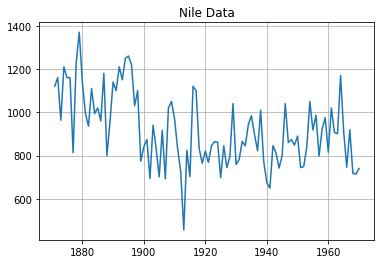

In [41]:
base_dir = pathlib.Path().resolve().parent
data_dir = base_dir / 'data'
nile_path = data_dir / 'Nile.txt'
llt_path = data_dir / 'llt.txt'
llts_path = data_dir / 'llts.txt'
lltsX_path = data_dir / 'lltsX.txt'
regression_y_path = data_dir / 'standard_regressionY.txt'
regression_x_path = data_dir / 'standard_regressionX.txt'
regressor_path = data_dir / 'regressor.txt'

nile_dates = pd.read_csv(nile_path).index
nile_data = pd.read_csv(nile_path).values

fig, ax = plt.subplots()
ax.plot(range(1871, 1871 + len(nile_data)), nile_data)
ax.grid()
ax.set_title('Nile Data')

# Log Likelihood Test: Numpy

In [80]:
# loglik test #1
y_test = np.ones((2,1,100))
F = np.ones((2,2,100))
for i in range(100):
    F[:, :, i] = np.eye(2,2)
y_test = np.ones((2,1,100))
v_test = np.ones((2,1,100))

# number of observations
n =  int(y_test.shape[2])

# dimension of observation vector
s = int(y_test.shape[0])

# get elementwise log determinants log|F|: check docs numpy returns (signs, abs of logdet)
F_logdets = np.linalg.slogdet(F.transpose(2, 0, 1))
F_logdets = F_logdets[0] * F_logdets[1]
    
# get elementwise v'F^(-1)v, then convert shape from [100, 1, 1] -> [100]
vFv = np.squeeze(_bmm3(v_test.transpose(2, 1, 0), _inv(F.transpose(2, 0, 1)), v_test.transpose(2, 0, 1)))
#print(v_test.transpose(2, 1, 0))

# constant value 
const = s * np.log(2 * np.pi) * np.ones_like(vFv)
    
# compute log-likelihood
llik = -(1/2) * np.sum(const + vFv + F_logdets) 

# test -> see notes for calculation
assert round(llik.item(),0) == -284.0 

print('Test completed succesfully! ')

Test completed succesfully! 


In [57]:
"""
y_t       = alpha_t + epsilon_t         w/ eps ~ N(0, var_eps)
alpha_t+1 = alpha_t + v_t + eta_t       w/ eta ~ N(0, var_eta)
v_t+1     = v_t + ksi_t                 w/ ksi ~ N(0, var_ksi)
"""

TEST_MISSING = False

### Want all tensors to be of shape [dimension, 1/dimension ,n]
dtype=np.float64

# load data, shape [s, n]
nile_data = pd.read_csv(nile_path).values * 0
Tn=500
nile_data = np.zeros((Tn,1))

var_season = 1
var_trend = 0.1
var_level = 1
var_obs = 10
var_exog = 20

EXOG = np.random.randint(0,2,Tn)

# Initializing a queue
days = deque()
for i in range(7):
    days.append(var_season*np.random.randn())

seasonality = np.zeros(Tn)
for i in range(1, len(EXOG)):
    days.popleft()
    seasonality[i] = -sum(days) +  (i/10) * var_season * np.random.randn()
    days.append(seasonality[i])

trend = np.zeros(Tn)
for i in range(1, len(trend)):
    trend[i] = trend[i-1] +  var_trend * np.random.randn()
    
slope_X = np.zeros(Tn) + 50
for i in range(1, len(slope_X)):
    slope_X[i] = slope_X[i-1] +  var_exog * np.random.randn()

level = np.zeros(Tn)
for i in range(1, len(trend)):
    level[i] = level[i-1] + trend[i-1] +  var_level * np.random.randn()

for i in range(1, len(nile_data)):
    nile_data[i] = level[i] + seasonality[i] + slope_X[i] * EXOG[i] + var_obs * np.random.randn()

if TEST_MISSING:
    nile_data[60:80] = torch.nan

y = nile_data.astype(dtype).T
np.savetxt(lltsX_path, y, delimiter=",")
np.savetxt(regressor_path, EXOG, delimiter=",")

# get data into shape [s, 1, n]
y = y[:, None, :]

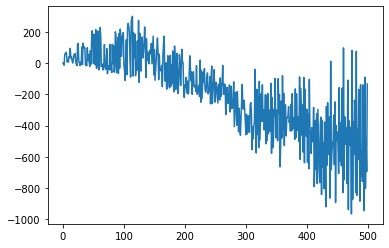

In [58]:
plt.plot(np.squeeze(y))

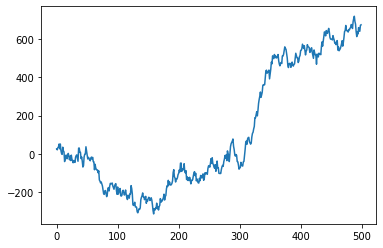

In [56]:
plt.plot(slope_X)

In [53]:
EXOG

array([1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1,
       1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0,
       1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0,
       1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0,
       0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0,
       1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1,
       1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1,
       1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1,
       0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1,
       1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1,
       1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0,
       1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1,
       1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1,

In [42]:
"""
y_t       = alpha_t + epsilon_t         w/ eps ~ N(0, var_eps)
alpha_t+1 = alpha_t + v_t + eta_t       w/ eta ~ N(0, var_eta)
v_t+1     = v_t + ksi_t                 w/ ksi ~ N(0, var_ksi)
"""

TEST_MISSING = False

### Want all tensors to be of shape [dimension, 1/dimension ,n]
dtype=np.float64

# load data, shape [s, n]
nile_data = pd.read_csv(nile_path).values * 0
Tn=500
nile_data = np.zeros((Tn,1))

var_obs = 1500

EXOG = np.random.rand(Tn) * 100

slope_X = np.zeros(Tn) + 100

for i in range(1, len(nile_data)):
    nile_data[i] = slope_X[i] * EXOG[i] + var_obs * np.random.randn()

if TEST_MISSING:
    nile_data[60:80] = torch.nan

y = nile_data.astype(dtype).T
np.savetxt(regression_y_path, y, delimiter=",")
np.savetxt(regression_x_path, EXOG, delimiter=",")

# get data into shape [s, 1, n]
y = y[:, None, :]

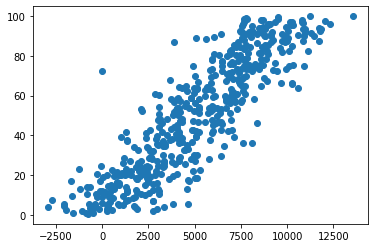

In [43]:
plt.scatter(np.squeeze(y), EXOG)